1. [Introduction](#1)
1. [Gather Sense of Our Data](#2)
1. [Scaling and Distributing](#3)
1. [Random Under-Sampling](#4)
1. [Correlations and outliers](#5)
1. [Dimensionality Reduction and Clustering](#6)
1. [Modeling with Undersampling](#7)
    - /!\ IMPORTANT NOTE /!\
    - Undersampling before cross validation (prone to overfit)
    - Undersampling during cross validation
1. [Oversampling with SMOTE techniques](#8)
    - SMOTE before cross-validation
    - SMOTE during cross-validation
1. [Neural Networks Testing Random UnderSampling Data vs OverSampling (SMOTE)](#9)
1. [Conclusion](#10)

<a id="1"></a> <br>
## Introduction 

In this kernel we will use various predictive models to see how accurate they are in detecting whether a transaction is a normal payment or a fraud. As described in the dataset, the features are scaled and the names of the features are not shown due to privacy reasons. Nevertheless, we can still analyze some important aspects of the dataset. We will use Undersampling and Oversampling

The main objectif of this notebook is to show a common mistake with cross-validation and imbalanced dataset and how to avoid her, let me explain.

In the context of many medical applications for example, we have datasets where we have two classes for the main outcome; normal samples and relevant samples. For example in a cancer detection application we might have a small percentages of patients with cancer (relevant samples) while the majority of samples might be healthy individuals. Outside of the medical space, this is true (even more) for the case for example of fraud detection, where the rate of relevant samples (i.e. frauds) to normal samples might be even in the order of 1 to 100 000.

The main motivation behind the need to preprocess imbalanced data before we feed them into a classifier is that typically classifiers are more sensitive to detecting the majority class and less sensitive to the minority class. Thus, if we don't take care of the issue, the classification output will be biased, in many cases resulting in always predicting the majority class. 

But we will see than preprocessing our data before cross-validation to deal with our imbalanced dataset can result sometime with biased result who tend to overfit. 

I will explain more in depth later in the notebook, for no let's star by gater some sense of the dataset.

<a id="2"></a> <br>
## Gather Sense of Our Data:

The first thing we must do is gather a basic sense of our data. Remember, except for the transaction and amount we dont know what the other columns are (due to privacy reasons). The only thing we know, is that those columns that are unknown have been scaled already.

In [44]:
# Imported Libraries

import numpy as np 
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
import sklearn.model_selection as ms
from lightgbm import LGBMClassifier
import xgboost as xgb
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import LinearSVC
from sklearn import tree
from sklearn import metrics
from sklearn import ensemble
from sklearn import linear_model 
from sklearn import naive_bayes 
from sklearn.svm import NuSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.ensemble import BaggingClassifier
from catboost import CatBoostRegressor
from sklearn.linear_model import RidgeClassifierCV
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier
from sklearn import model_selection

# Keras

import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy

# Other Libraries
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, StratifiedShuffleSplit
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, confusion_matrix
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


I recently discovered pandas_profiling. It Generates profile reports from a pandas DataFrame. The pandas df.describe() function is great but a little basic for serious exploratory data analysis. pandas_profiling extends the pandas DataFrame with df.profile_report() for quick data analysis. It provide a great detailed overview on the variable, the interactions between them, the correlations (with multiple methods), the missing values and so on. 

Here I generate a html files to my folder, it will not render in this notebook.

If you want to display it in your own computer within your folder :

- Install it with : `pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip`
- Discover it with https://www.datacorner.fr/pandas-profiling/
- And just run the code below with your own dataframe and here we go. 

In [13]:
from pandas_profiling import ProfileReport


prof = ProfileReport(df)

prof.to_file(output_file='rapport.html')


In [5]:
df.isnull().sum().max()

0

No null value, that's convenient.

In [7]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [24]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [135]:
print('There are {:.4}% cases of No Frauds'.format(df['Class'].value_counts(normalize = True)[0]*100))

There are 99.83% cases of No Frauds


In [136]:
print('There are {:.2}% cases of Frauds'.format(df['Class'].value_counts(normalize = True)[1]*100))

There are 0.17% cases of Frauds


Clearly the dataset is imbalanced. If we use this dataframe as the base for our predictive models and analysis we might get a lot of errors and our algorithms will probably overfit since it will "assume" that most transactions are not fraud. But we don't want our model to assume, we want our model to detect patterns that give signs of fraud !

<a id="3"></a> <br>
## Scaling and Distributing
In this phase of our kernel, we will first scale the columns comprise of Time and Amount . Time and amount should be scaled as the other columns. On the other hand, we need to also create a sub sample of the dataframe in order to have an equal amount of Fraud and Non-Fraud cases, helping our algorithms better understand patterns that determines whether a transaction is a fraud or not.

Since most of our data has already been scaled we should scale the columns that are left to scale (Amount and Time)

In [3]:
# RobustScaler is less prone to outliers.

scaler = RobustScaler()

df['scaled_amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time', 'Amount'], axis = 1, inplace = True)

In [4]:
scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

# Amount and Time are Scaled!

df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


Let's split our data for later (for the part with SMOTE) :

In [5]:
X = df.drop('Class', axis=1)
y = df['Class']

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

# Turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

In [6]:
print(original_Xtrain.shape)
print(original_Xtest.shape)
print(original_ytrain.shape)
print(original_ytest.shape)

(227846, 30)
(56961, 30)
(227846,)
(56961,)


<a id="4"></a> <br>
## Random Under-Sampling 

The main issue with "Random Under-Sampling" is that we run the risk that our classification models will not perform as accurate as we would like to since there is a great deal of information loss (bringing 492 non-fraud transaction from 284,315 non-fraud transaction).

Since our classes are highly skewed we should make them equivalent in order to have a normal distribution of the classes. Lets shuffle the data before creating the subsamples

In [7]:
df = df.sample(frac=1)

In [8]:
fraud_df = df[df['Class'] == 1]
no_fraud_df = df[df['Class'] == 0][:492]

new_data = pd.concat([fraud_df, no_fraud_df])

new_df = new_data.sample(frac=1, random_state = 42)

new_df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
48511,8.868860,-0.481843,-1.363320,-1.106436,0.480856,-0.249311,-1.972768,-0.032278,2.869187,-0.364403,...,1.410398,0.479850,0.203732,1.336057,0.376085,0.169504,1.041418,-0.265370,0.088201,0
147605,-0.178719,0.047522,1.917827,0.951967,-2.059206,3.833998,1.668192,0.769826,0.232463,0.107941,...,-0.115922,0.015255,0.239994,-0.111916,-0.380576,0.370995,0.189117,-0.005823,-0.012105,1
162347,-0.269825,0.356489,0.146978,1.070401,-0.441586,-0.583173,1.055385,-0.672665,0.997873,-0.112035,...,0.054450,-0.336911,-0.783379,0.079143,0.430056,-0.399726,0.122698,0.229495,0.083878,0
281144,3.116048,1.001821,-3.113832,0.585864,-5.399730,1.817092,-0.840618,-2.943548,-2.208002,1.058733,...,0.306271,0.583276,-0.269209,-0.456108,-0.183659,-0.328168,0.606116,0.884876,-0.253700,1
191359,-0.239363,0.523150,1.177824,2.487103,-5.330608,5.324547,1.150243,-1.281843,-1.171994,0.413778,...,0.156057,0.262325,-0.431790,-0.092088,0.145216,0.457788,0.167739,0.451243,0.268421,1


In [9]:
new_df['Class'].value_counts()

1    492
0    492
Name: Class, dtype: int64

Great !

Now that we have our dataframe correctly balanced, we can go further with our analysis and data preprocessing.

<a id="5"></a> <br>
## Correlations and outliers

Let's first check the correlations matrices. Correlation matrices are the essence of understanding our data. We want to know if there are features that influence heavily in whether a specific transaction is a fraud. However, it is important that we use the correct dataframe (subsample) in order for us to see which features have a high positive or negative correlation with regards to fraud transactions.

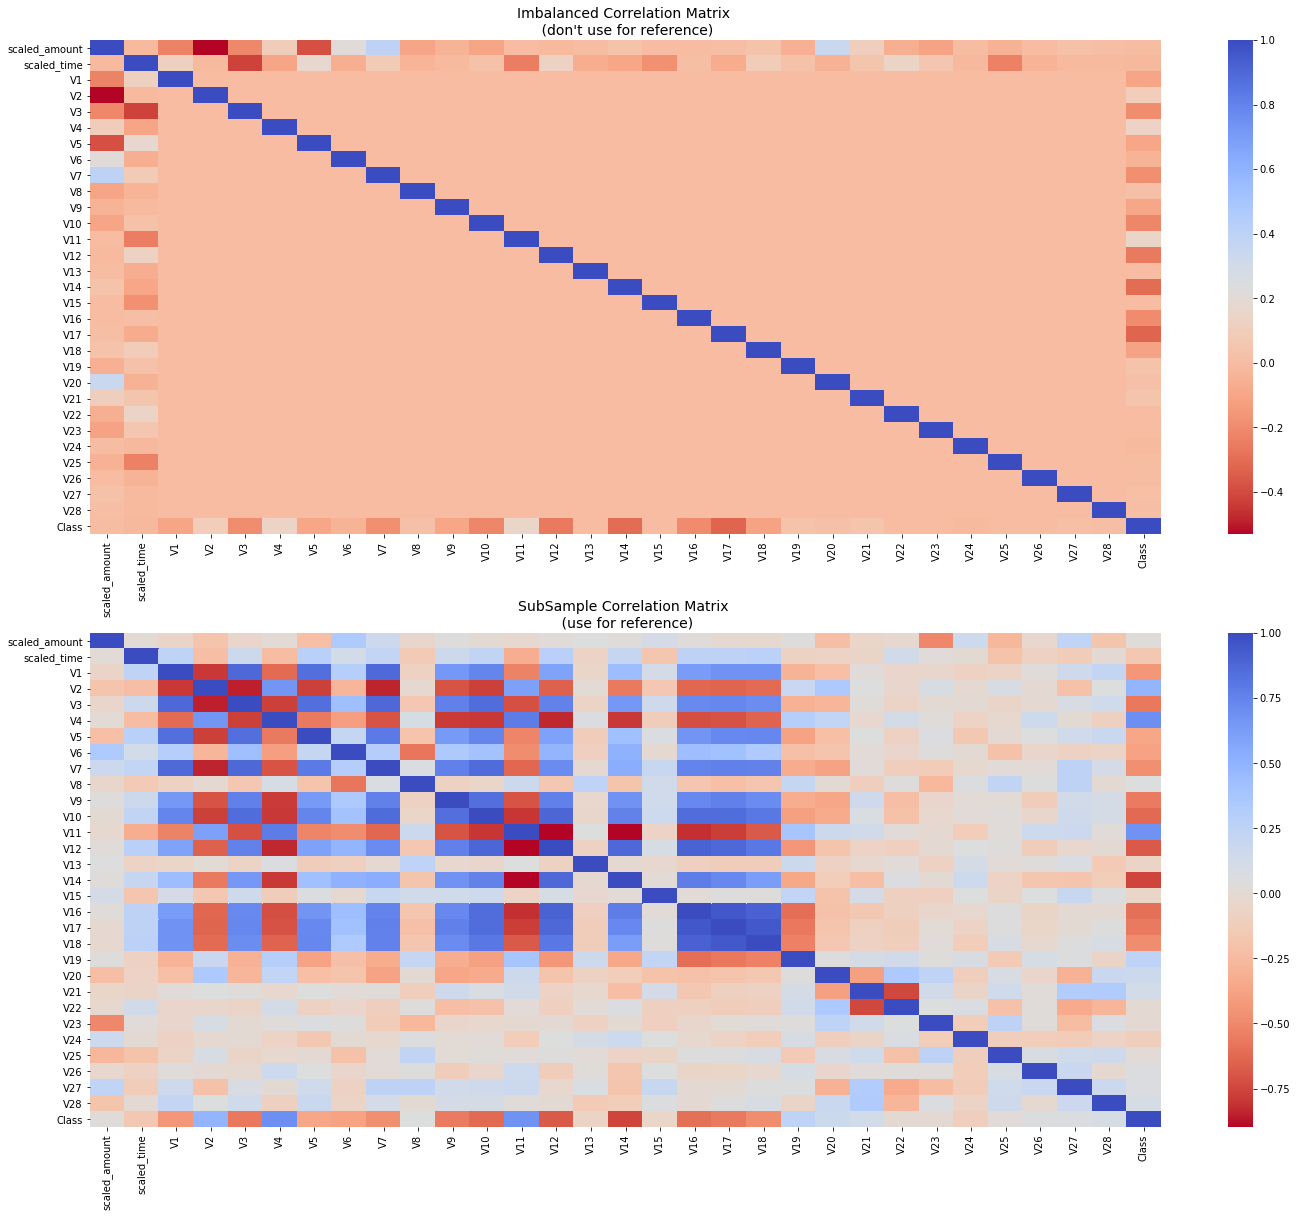

In [177]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

# Entire DataFrame
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix \n (don't use for reference)", fontsize=14)


sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title('SubSample Correlation Matrix \n (use for reference)', fontsize=14)
plt.show()

- `V17`, `V14`, `V12` and `V10` are negatively correlated. Notice how the lower these values are, the more likely the end result will be a fraud transaction.


- `V2`, `V4`, `V11`, and `V19` are positively correlated. Notice how the higher these values are, the more likely the end result will be a fraud transaction.

Let's analyse those variable more in depth with boxplot

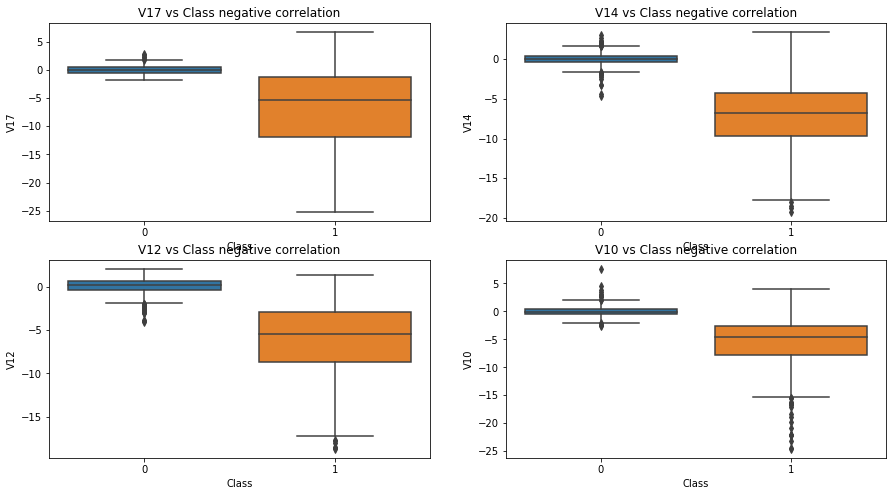

In [178]:
f, axes = plt.subplots(ncols = 2, nrows = 2, figsize = (15,8))

sns.boxplot(x = 'Class', y = 'V17', data = new_df, ax = axes[0][0])
axes[0][0].set_title('V17 vs Class negative correlation')

sns.boxplot(x = 'Class', y = 'V14', data = new_df, ax = axes[0][1])
axes[0][1].set_title('V14 vs Class negative correlation')

sns.boxplot(x = 'Class', y = 'V12', data = new_df, ax = axes[1][0])
axes[1][0].set_title('V12 vs Class negative correlation')

sns.boxplot(x = 'Class', y = 'V10', data = new_df, ax = axes[1][1])
axes[1][1].set_title('V10 vs Class negative correlation')

plt.show()

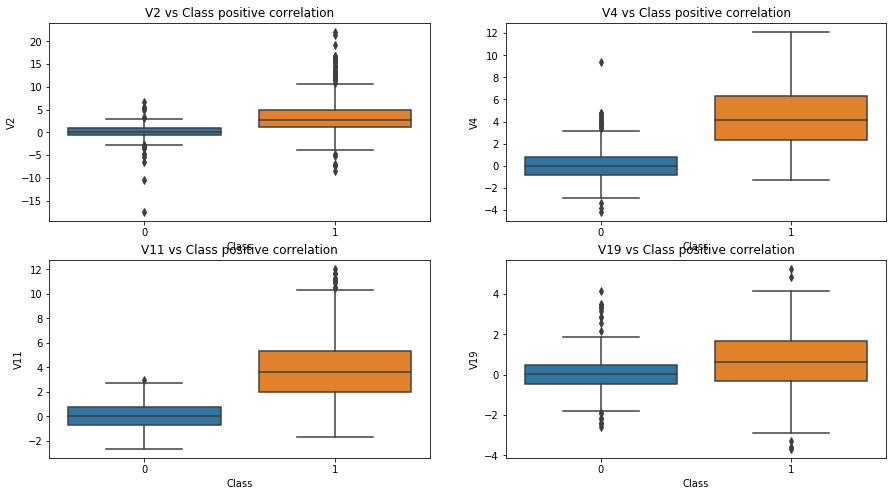

In [179]:
f, axes = plt.subplots(ncols = 2, nrows = 2, figsize = (15,8))

sns.boxplot(x = 'Class', y = 'V2', data = new_df, ax = axes[0][0])
axes[0][0].set_title('V2 vs Class positive correlation')

sns.boxplot(x = 'Class', y = 'V4', data = new_df, ax = axes[0][1])
axes[0][1].set_title('V4 vs Class positive correlation')

sns.boxplot(x = 'Class', y = 'V11', data = new_df, ax = axes[1][0])
axes[1][0].set_title('V11 vs Class positive correlation')

sns.boxplot(x = 'Class', y = 'V19', data = new_df, ax = axes[1][1])
axes[1][1].set_title('V19 vs Class positive correlation')

plt.show()

Our main aim in this section is to remove "extreme outliers" from features that have a high correlation with our classes. This will have a positive impact on the accuracy of our models.

We have to be careful as to how far do we want the threshold for removing outliers. We determine the threshold by multiplying a number (ex: 1.5) by the "Interquartile Range" (difference between the 75th percentile and 25th percentile). The higher this threshold is, the less outliers will detect (multiplying by a higher number ex: 3), and the lower this threshold is the more outliers it will detect.

*The Tradeoff*: The lower the threshold the more outliers it will remove however, we want to focus more on "extreme outliers" rather than just outliers. Why? because we might run the risk of information loss which will cause our models to have a lower accuracy. You can play with this threshold and see how it affects the accuracy of our classification models.

Let's remove the outlier carefully !

**V14**

In [10]:
v14_fraud = new_df.loc[new_df['Class'] == 1, 'V14'].values

q25, q75 = np.percentile(v14_fraud, 25), np.percentile(v14_fraud, 75)

print('Quartile 25 : {} | Quartile 75 : {}'.format(q25, q75))

v14_iqr = q75 - q25

print('\niqr :', v14_iqr)

v14_cut_off = v14_iqr * 1.5
v14_lower, v14_upper = q25 - v14_cut_off, q75 + v14_cut_off
print('\nCut Off: {}'.format(v14_cut_off))
print('\nV14 Lower: {}'.format(v14_lower))
print('\nV14 Upper: {}'.format(v14_upper))

outliers = [x for x in v14_fraud if x < v14_lower or x > v14_upper]

print('\nNumber of outliers for the variable V14 :', len(outliers))

new_df = new_df.drop(new_df[(new_df['V14'] > v14_upper) | (new_df['V14'] < v14_lower)].index)

Quartile 25 : -9.692722964972385 | Quartile 75 : -4.282820849486866

iqr : 5.409902115485519

Cut Off: 8.114853173228278

V14 Lower: -17.807576138200663

V14 Upper: 3.8320323237414122

Number of outliers for the variable V14 : 4


To gain some time, let's create a function to remove the outliers like above. 

In [11]:
def remove_outliers(variable, df):
    
    var_fraud = df.loc[df['Class'] == 1, variable].values

    q25, q75 = np.percentile(var_fraud, 25), np.percentile(var_fraud, 75)

    print('Quartile 25 : {} | Quartile 75 : {}'.format(q25, q75))

    var_iqr = q75 - q25

    print('\niqr :', var_iqr)

    var_cut_off = var_iqr * 1.5
    var_lower, var_upper = q25 - var_cut_off, q75 + var_cut_off
    print('\nCut Off: {}'.format(var_cut_off))
    print('\nV14 Lower: {}'.format(var_lower))
    print('\nV14 Upper: {}'.format(var_upper))

    outliers = [x for x in var_fraud if x < var_lower or x > var_upper]

    print('\nNumber of outliers for the variable  :', len(outliers))

    df = df.drop(df[(df[variable] > var_upper) | (df[variable] < var_lower)].index)
    
    return df

**V12**

In [12]:
new_df2 = remove_outliers('V12', new_df)

Quartile 25 : -8.67303320439115 | Quartile 75 : -2.893030568676315

iqr : 5.780002635714835

Cut Off: 8.670003953572252

V14 Lower: -17.3430371579634

V14 Upper: 5.776973384895937

Number of outliers for the variable  : 4


**V11**

In [13]:
new_df3 = remove_outliers('V11', new_df2)

Quartile 25 : 1.9620472137916574 | Quartile 75 : 5.20664237764091

iqr : 3.2445951638492527

Cut Off: 4.866892745773879

V14 Lower: -2.9048455319822217

V14 Upper: 10.07353512341479

Number of outliers for the variable  : 8


**V2**

In [14]:
new_df4 = remove_outliers('V2', new_df3)

Quartile 25 : 1.1536685808488225 | Quartile 75 : 4.570172224572338

iqr : 3.4165036437235154

Cut Off: 5.124755465585273

V14 Lower: -3.9710868847364504

V14 Upper: 9.694927690157611

Number of outliers for the variable  : 52


**V19**

In [15]:
new_df5 = remove_outliers('V19', new_df4)

Quartile 25 : -0.44563692232515 | Quartile 75 : 1.74628318636648

iqr : 2.19192010869163

Cut Off: 3.2878801630374452

V14 Lower: -3.733517085362595

V14 Upper: 5.034163349403926

Number of outliers for the variable  : 1


**V10**

In [16]:
new_df6 = remove_outliers('V10', new_df5)

Quartile 25 : -6.253474349781204 | Quartile 75 : -2.24359071750455

iqr : 4.009883632276654

Cut Off: 6.01482544841498

V14 Lower: -12.268299798196184

V14 Upper: 3.7712347309104297

Number of outliers for the variable  : 42


**V17**

In [17]:
new_df7 = remove_outliers('V17', new_df6)

Quartile 25 : -7.17167241498026 | Quartile 75 : -0.0524194348357059

iqr : 7.119252980144554

Cut Off: 10.678879470216831

V14 Lower: -17.850551885197092

V14 Upper: 10.626460035381125

Number of outliers for the variable  : 9


**V4**

In [18]:
new_df8 = remove_outliers('V4', new_df7)

Quartile 25 : 1.9973975949141598 | Quartile 75 : 5.175484518182389

iqr : 3.1780869232682294

Cut Off: 4.7671303849023445

V14 Lower: -2.7697327899881845

V14 Upper: 9.942614903084735

Number of outliers for the variable  : 0


In [19]:
print('Size of the dataset with outliers removed :', len(new_df8))

Size of the dataset with outliers removed : 841


In [20]:
new_df = new_df8

<a id="6"></a> <br>
## Dimensionality Reduction and Clustering:

Those kind of methods allow us to visualize multi dimension ( number of variable > 2), here 30) more easily. Therefore, to see if the two labels (fraud/no fraud) could be easily distinguish.

In [21]:
X = new_df.drop('Class', axis = 1)
y = new_df.Class

In [205]:
t0 = time.time()
X_tsne = TSNE(n_components = 2, random_state = 42).fit_transform(X.values)
t1 = time.time()
print('TSNE took {:.2} s'.format(t1 - t0))

t0 = time.time()
X_PCA = PCA(n_components = 2, random_state = 42).fit_transform(X.values)
t1 = time.time()
print('PCA took {:.2} s'.format(t1 - t0))

t0 = time.time()
X_SVD = TruncatedSVD(n_components = 2, algorithm='randomized', random_state = 42).fit_transform(X.values)
t1 = time.time()
print('SVD took {:.2} s'.format(t1 - t0))

TSNE took 5.4 s
PCA took 0.0055 s
SVD took 0.0056 s


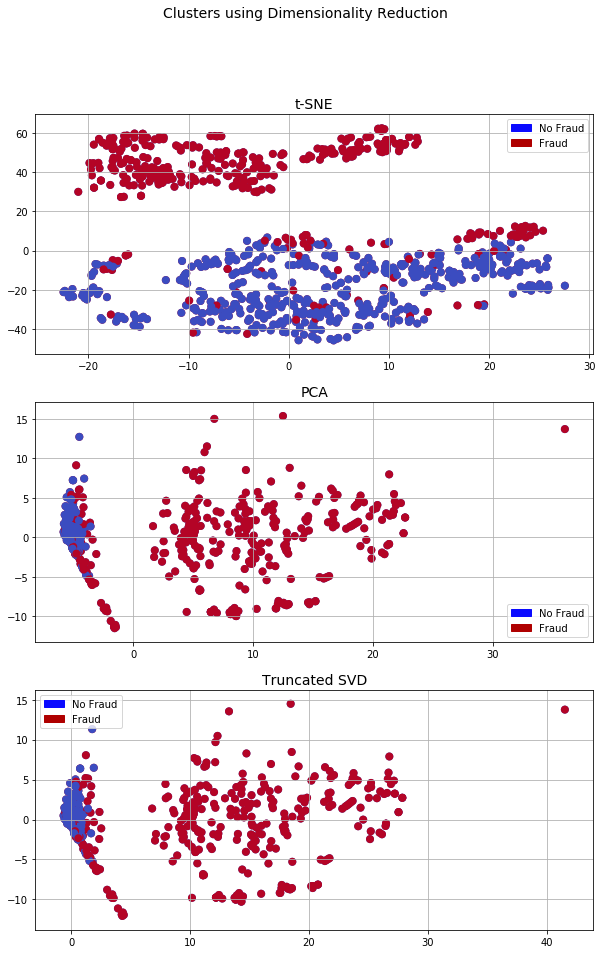

In [211]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10,15))
# labels = ['No Fraud', 'Fraud']
f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)


blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')


# t-SNE scatter plot
ax1.scatter(X_tsne[:,0], X_tsne[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax1.scatter(X_tsne[:,0], X_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)

ax1.grid(True)

ax1.legend(handles=[blue_patch, red_patch])


# PCA scatter plot
ax2.scatter(X_PCA[:,0], X_PCA[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax2.scatter(X_PCA[:,0], X_PCA[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax2.set_title('PCA', fontsize=14)

ax2.grid(True)

ax2.legend(handles=[blue_patch, red_patch])

# TruncatedSVD scatter plot
ax3.scatter(X_SVD[:,0], X_SVD[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax3.scatter(X_SVD[:,0], X_SVD[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)

ax3.grid(True)

ax3.legend(handles=[blue_patch, red_patch])

plt.show()

t-SNE algorithm can pretty accurately cluster the cases that were fraud and non-fraud in our dataset. Although the subsample is pretty small, the t-SNE algorithm is able to detect clusters pretty accurately in every scenario (I shuffle the dataset before running t-SNE). This gives us an indication that further predictive models will perform pretty well in separating fraud cases from non-fraud cases.

<a id="7"></a> <br>
## Modeling with Undersampling

/!\ *IMPORTANT NOTE* /!\

Before we go on, I need to mention a very interesting point that I discover recently, I mentionned it earlier in the introduction :

*Cross Validation Overfitting Mistake*

If you want to undersample or oversample your data you should not do it before cross validating. Why because you will be directly influencing the validation set before implementing cross-validation causing a "data leakage" problem. In the following section you will see amazing precision and recall scores but in reality our data is overfitting! 

If we get the minority class ("Fraud) in our case, and create the synthetic points before cross validating we have a certain influence on the "validation set" of the cross validation process. Remember how cross validation works, let's assume we are splitting the data into 5 batches, 4/5 of the dataset will be the training set while 1/5 will be the validation set. The test set should not be touched! For that reason, we have to do the creation of synthetic datapoints "during" cross-validation and not before

For good measure I will show the undersampling before cross-validation and the undersampling during cross validation

**Undersampling before cross validation (prone to overfit)**

In [22]:
X = new_df.drop('Class', axis=1)
y = new_df['Class']

In [23]:
# Our data is already scaled we should split our training and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
# Turn the values into an array for feeding the classification algorithms.
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

Just for fun, I will test my data on almost all model available in scikit learn and see how it goes. I can afford that because my computer is not that bad, moreover the undersampling dataset is very small so it will not take forever but in other cases, I will not put so much different models.

We will sort by the result of test_score, because train_score is much more prone to overfitting. Hence it's way better to look at test score instead.

In [41]:
#Machine Learning Algorithm (MLA) Selection and Initialization
MLA = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),

    #Gaussian Processes
    gaussian_process.GaussianProcessClassifier(),
    
    #GLM
    LogisticRegression(),
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    #Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),

    
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    #SVM
    svm.SVC(probability=True),
    svm.NuSVC(probability=True),
    svm.LinearSVC(),
    
    #Trees    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    #Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),

    
    #xgboost
    XGBClassifier(),
    LGBMClassifier()
    ]


cv_split =  StratifiedKFold(n_splits=10, random_state=42)

#create table to compare MLA metrics
MLA_columns = ['MLA Name', 'MLA Parameters','MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD' ,'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)

#create table to compare MLA predictions
MLA_predict = y

#index through MLA and save performance to table
row_index = 0
for alg in MLA:

    #set name and parameters
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
    
    cv_results = model_selection.cross_validate(alg, X, y, cv  = cv_split, return_train_score = True, scoring = 'accuracy')

    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()   
    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3   

    
    row_index+=1

    
MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
MLA_compare

,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time
7,LogisticRegressionCV,"{'Cs': 10, 'class_weight': None, 'cv': None, '...",0.949003,0.94056,0.0388996,0.687372
23,LGBMClassifier,"{'boosting_type': 'gbdt', 'class_weight': None...",1,0.939384,0.0460052,0.363971
6,LogisticRegression,"{'C': 1.0, 'class_weight': None, 'dual': False...",0.950324,0.938179,0.0653596,0.0165622
4,RandomForestClassifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",1,0.938165,0.050034,0.216854
22,XGBClassifier,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.997622,0.937017,0.0499997,0.176917
17,LinearSVC,"{'C': 1.0, 'class_weight': None, 'dual': True,...",0.950984,0.936989,0.0658594,0.0236863
0,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",0.994055,0.933431,0.0360263,0.139848
14,KNeighborsClassifier,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.952438,0.932283,0.0791381,0.00409355
15,SVC,"{'C': 1.0, 'break_ties': False, 'cache_size': ...",0.946492,0.932213,0.0679374,0.0329798
3,GradientBoostingClassifier,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...",0.999207,0.93105,0.0443324,0.482761


In [43]:
cv_split = KFold = StratifiedKFold(n_splits=10, random_state=42)

#create table to compare MLA metrics
MLA_columns = ['MLA Name', 'MLA Parameters','MLA Train AUC Mean', 'MLA Test AUC Mean', 'MLA Test AUC 3*STD' ,'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)

#create table to compare MLA predictions
MLA_predict = y

#index through MLA and save performance to table
row_index = 0
for alg in MLA:

    #set name and parameters
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
    
    cv_results = model_selection.cross_validate(alg, X, y, cv  = cv_split, return_train_score = True, scoring = 'roc_auc')

    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train AUC Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test AUC Mean'] = cv_results['test_score'].mean()   
    MLA_compare.loc[row_index, 'MLA Test AUC 3*STD'] = cv_results['test_score'].std()*3   

    
    row_index+=1

    
MLA_compare.sort_values(by = ['MLA Test AUC Mean'], ascending = False, inplace = True)
MLA_compare

,MLA Name,MLA Parameters,MLA Train AUC Mean,MLA Test AUC Mean,MLA Test AUC 3*STD,MLA Time
7,LogisticRegressionCV,"{'Cs': 10, 'class_weight': None, 'cv': None, '...",0.984009,0.978079,0.0297294,0.676885
3,GradientBoostingClassifier,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...",0.999999,0.975197,0.0373813,0.481314
15,SVC,"{'C': 1.0, 'break_ties': False, 'cache_size': ...",0.985432,0.975125,0.0383874,0.033806
6,LogisticRegression,"{'C': 1.0, 'class_weight': None, 'dual': False...",0.986641,0.97499,0.0296546,0.0171545
22,XGBClassifier,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.999987,0.974068,0.0413047,0.167249
23,LGBMClassifier,"{'boosting_type': 'gbdt', 'class_weight': None...",1,0.973506,0.0386029,0.358439
2,ExtraTreesClassifier,"{'bootstrap': False, 'ccp_alpha': 0.0, 'class_...",1,0.973371,0.0513336,0.108307
17,LinearSVC,"{'C': 1.0, 'class_weight': None, 'dual': True,...",0.987124,0.972881,0.0363676,0.0234368
0,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",0.999898,0.970691,0.053531,0.151799
9,RidgeClassifierCV,"{'alphas': array([ 0.1, 1. , 10. ]), 'class_w...",0.977119,0.9705,0.0524745,0.00436721


As we can see, we obtained some nice results, we can even see some 1 on the train_score, clearly some overfitting, it's usual with train_score, it's far more convenient to see the test_score. The best is to have a result close to 1 with test_score and train_score is very close to test_score. That means great results and probably not overfitting.

Let's see if we undersample **during** cross-validation.

**Undersampling during cross validation**

We will use Logistic regression for now.

In [39]:
undersample_X = df.drop('Class', axis=1)
undersample_y = df['Class']

log_reg = LogisticRegression().fit(undersample_X, undersample_y)

In [11]:
sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)


for train_index, test_index in sss.split(undersample_X, undersample_y):
    undersample_Xtrain, undersample_Xtest = undersample_X.iloc[train_index], undersample_X.iloc[test_index]
    undersample_ytrain, undersample_ytest = undersample_y.iloc[train_index], undersample_y.iloc[test_index]
    
undersample_Xtrain = undersample_Xtrain.values
undersample_Xtest = undersample_Xtest.values
undersample_ytrain = undersample_ytrain.values
undersample_ytest = undersample_ytest.values 

undersample_accuracy = []
undersample_precision = []
undersample_recall = []
undersample_f1 = []
undersample_auc = []

for train, test in sss.split(undersample_Xtrain, undersample_ytrain):
    undersample_pipeline = imbalanced_make_pipeline(NearMiss(sampling_strategy='majority'), log_reg) # Undersampling happens during Cross Validation not before..
    undersample_model = undersample_pipeline.fit(undersample_Xtrain[train], undersample_ytrain[train])
    undersample_prediction = undersample_model.predict(undersample_Xtrain[test])
    
    undersample_accuracy.append(undersample_pipeline.score(original_Xtrain[test], original_ytrain[test]))
    undersample_precision.append(precision_score(original_ytrain[test], undersample_prediction))
    undersample_recall.append(recall_score(original_ytrain[test], undersample_prediction))
    undersample_f1.append(f1_score(original_ytrain[test], undersample_prediction))
    undersample_auc.append(roc_auc_score(original_ytrain[test], undersample_prediction))

In [14]:
print('Average accuracy obtained when we undersample during cross-validation : {:.3}'.format(np.mean(undersample_accuracy)))
print('')
print('Average precision obtained when we undersample during cross-validation : {:.3}'.format(np.mean(undersample_precision)))
print('')
print('Average recall obtained when we undersample during cross-validation : {:.3}'.format(np.mean(undersample_recall)))
print('')
print('Average f1-score obtained when we undersample during cross-validation : {:.3}'.format(np.mean(undersample_f1)))
print('')
print('Average AUC obtained when we undersample during cross-validation : {:.3}'.format(np.mean(undersample_auc)))

Average accuracy obtained when we undersample during cross-validation : 0.565

Average precision obtained when we undersample during cross-validation : 0.00414

Average recall obtained when we undersample during cross-validation : 0.954

Average f1-score obtained when we undersample during cross-validation : 0.00824

Average AUC obtained when we undersample during cross-validation : 0.759


The results are much worse, that's confirm if we undersample before cross-validation, the risk of overfitting is here. We need to watch out for this in the futur. 

Let's try with some others models :

In [40]:
def undersample_cv(model, name):

    sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)


    for train_index, test_index in sss.split(undersample_X, undersample_y):
        undersample_Xtrain, undersample_Xtest = undersample_X.iloc[train_index], undersample_X.iloc[test_index]
        undersample_ytrain, undersample_ytest = undersample_y.iloc[train_index], undersample_y.iloc[test_index]
    
    undersample_Xtrain = undersample_Xtrain.values
    undersample_Xtest = undersample_Xtest.values
    undersample_ytrain = undersample_ytrain.values
    undersample_ytest = undersample_ytest.values 

    undersample_accuracy = []
    undersample_precision = []
    undersample_recall = []
    undersample_f1 = []
    undersample_auc = []
    
    
    for train, test in sss.split(undersample_Xtrain, undersample_ytrain):
        undersample_pipeline = imbalanced_make_pipeline(NearMiss(sampling_strategy='majority'), model) 
        undersample_model = undersample_pipeline.fit(undersample_Xtrain[train], undersample_ytrain[train])
        undersample_prediction = undersample_model.predict(undersample_Xtrain[test])
    
        undersample_accuracy.append(undersample_pipeline.score(original_Xtrain[test], original_ytrain[test]))
        undersample_precision.append(precision_score(original_ytrain[test], undersample_prediction))
        undersample_recall.append(recall_score(original_ytrain[test], undersample_prediction))
        undersample_f1.append(f1_score(original_ytrain[test], undersample_prediction))
        undersample_auc.append(roc_auc_score(original_ytrain[test], undersample_prediction))
    
    
    print('The result for {} is:'.format(name))
    print('')
    print('Average accuracy obtained when we undersample during cross-validation : {:.3}'.format(np.mean(undersample_accuracy)))
    print('')
    print('Average precision obtained when we undersample during cross-validation : {:.3}'.format(np.mean(undersample_precision)))
    print('')
    print('Average recall obtained when we undersample during cross-validation : {:.3}'.format(np.mean(undersample_recall)))
    print('')
    print('Average f1-score obtained when we undersample during cross-validation : {:.3}'.format(np.mean(undersample_f1)))
    print('')
    print('Average AUC obtained when we undersample during cross-validation : {:.3}'.format(np.mean(undersample_auc)))

In [145]:
LGBM = LGBMClassifier()
undersample_cv(LGBM, 'LGBM')

The result for LGBM is:

Average accuracy obtained when we undersample during cross-validation : 0.0996

Average precision obtained when we undersample during cross-validation : 0.00186

Average recall obtained when we undersample during cross-validation : 0.967

Average f1-score obtained when we undersample during cross-validation : 0.00371

Average AUC obtained when we undersample during cross-validation : 0.533


In [146]:
Xgboost = xgb.XGBClassifier()
undersample_cv(Xgboost, 'Xgboost')

The result for Xgboost is:

Average accuracy obtained when we undersample during cross-validation : 0.128

Average precision obtained when we undersample during cross-validation : 0.00192

Average recall obtained when we undersample during cross-validation : 0.967

Average f1-score obtained when we undersample during cross-validation : 0.00383

Average AUC obtained when we undersample during cross-validation : 0.547


In [147]:
extra_tree = ensemble.ExtraTreesClassifier()
undersample_cv(extra_tree, 'extra_tree')

The result for extra_tree is:

Average accuracy obtained when we undersample during cross-validation : 0.107

Average precision obtained when we undersample during cross-validation : 0.00189

Average recall obtained when we undersample during cross-validation : 0.97

Average f1-score obtained when we undersample during cross-validation : 0.00377

Average AUC obtained when we undersample during cross-validation : 0.538


In [41]:
RF = ensemble.RandomForestClassifier()
undersample_cv(RF, 'Random Forest')

The result for Random Forest is:

Average accuracy obtained when we undersample during cross-validation : 0.126

Average precision obtained when we undersample during cross-validation : 0.00181

Average recall obtained when we undersample during cross-validation : 0.924

Average f1-score obtained when we undersample during cross-validation : 0.00361

Average AUC obtained when we undersample during cross-validation : 0.526


I think we got the point, the result are clearly worse. Before we try oversampling, I would like to know the most important feature in this case. I will pick Random Forest for this.

In [42]:
RF = ensemble.RandomForestClassifier().fit(X_train, y_train)

In [46]:
#conda install -c conda-forge eli5
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(RF, random_state = 0).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X.columns.tolist())

Weight,Feature
0.0690 ± 0.0556,V14
0.0107 ± 0.0231,V12
0.0107 ± 0.0089,V11
0.0083 ± 0.0193,V4
0.0060 ± 0.0075,V10
0.0024 ± 0.0058,V23
0.0012 ± 0.0048,scaled_amount
0.0012 ± 0.0048,V5
0 ± 0.0000,V8
0 ± 0.0000,V13


Here, we don't know the exact name of the feature because the company wanted to preserve the anonymity of the data but it's good to know how to do this.

Let's move on with the oversampling method.

<a id="8"></a> <br>
## Oversampling with SMOTE techniques

SMOTE creates synthetic points from the minority class in order to reach an equal balance between the minority and majority class. More information is retained since we didn't have to delete any rows unlike in random undersampling.
Although it is likely that SMOTE will be more accurate than random under-sampling, it will take more time to train since no rows are eliminated as previously stated.

Like the part with undersampling, we will show the result with oversampling before cross-validation and oversampling during cross-validation.

**SMOTE before cross-validation**

In [21]:
sampler = SMOTE(sampling_strategy='minority')
X_rs, y_rs = sampler.fit_sample(original_Xtrain, original_ytrain)

In [31]:
KFold = StratifiedKFold(n_splits=3, random_state=42)
scores = {}

def score_model(model):
    return cross_val_score(model, X_rs, y_rs, scoring='roc_auc', cv = KFold)


scores['tree'] = score_model(tree.DecisionTreeClassifier())

# time: 9s
scores['extra_tree'] = score_model(ensemble.ExtraTreesClassifier())

# time: 7s
scores['forest'] = score_model(ensemble.RandomForestClassifier())

# time: 33s
scores['ada_boost'] = score_model(ensemble.AdaBoostClassifier())

# time: 1min
scores['bagging'] = score_model(ensemble.BaggingClassifier())

# time: 2min30s
scores['grad_boost'] = score_model(ensemble.GradientBoostingClassifier())

# time: 49s
scores['ridge'] = score_model(linear_model.RidgeClassifier())

# time: 4s
scores['passive'] = score_model(linear_model.PassiveAggressiveClassifier())

# time: 4s
scores['sgd'] = score_model(linear_model.SGDClassifier())


# time: 4min
scores['xgboost'] = score_model(xgb.XGBClassifier())

scores['LightGBM'] = score_model(LGBMClassifier())

scores['LinearSVC'] = score_model(LinearSVC())

scores['LR'] = score_model(LogisticRegression())

In [33]:
model_scores = pd.DataFrame(scores).mean()
model_scores = model_scores.sort_values(ascending=False)
#model_scores.to_csv('model_scores.csv', index=False)
print('Model scores\n{}'.format(model_scores))

Model scores
extra_tree    0.999914
forest        0.999774
sgd           0.975350
LinearSVC     0.972755
LR            0.972743
passive       0.972587
grad_boost    0.972135
LightGBM      0.962589
xgboost       0.962357
ridge         0.953705
ada_boost     0.735199
bagging       0.680866
tree          0.665948
dtype: float64


That's what I call nice result but maybe our models overfit, let's see.

**SMOTE during cross-validation**

In [75]:
accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []

# Classifier with optimal parameters
# log_reg_sm = grid_log_reg.best_estimator_
log_reg_sm = LogisticRegression()


# Implementing SMOTE Technique 
# Cross Validating the right way
# Parameters

for train, test in sss.split(original_Xtrain, original_ytrain):
    pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), log_reg_sm) # SMOTE happens during Cross Validation not before..
    model = pipeline.fit(original_Xtrain[train], original_ytrain[train])
    prediction = model.predict(original_Xtrain[test])
    
    accuracy_lst.append(pipeline.score(original_Xtrain[test], original_ytrain[test]))
    precision_lst.append(precision_score(original_ytrain[test], prediction))
    recall_lst.append(recall_score(original_ytrain[test], prediction))
    f1_lst.append(f1_score(original_ytrain[test], prediction))
    auc_lst.append(roc_auc_score(original_ytrain[test], prediction))
    
print('Average accuracy obtained when we oversample during cross-validation : {:.3}'.format(np.mean(accuracy_lst)))
print('')
print('Average precision obtained when we oversample during cross-validation : {:.3}'.format(np.mean(precision_lst)))
print('')
print('Average recall obtained when we oversample during cross-validation : {:.3}'.format(np.mean(recall_lst)))
print('')
print('Average f1-score obtained when we oversample during cross-validation : {:.3}'.format(np.mean(f1_lst)))
print('')
print('Average AUC obtained when we oversample during cross-validation : {:.3}'.format(np.mean(auc_lst)))

Average accuracy obtained when we oversample during cross-validation : 0.942

Average precision obtained when we oversample during cross-validation : 0.0618

Average recall obtained when we oversample during cross-validation : 0.914

Average f1-score obtained when we oversample during cross-validation : 0.114

Average AUC obtained when we oversample during cross-validation : 0.928


It's not that bad, but clearly there is a problem.

In [36]:
labels = ['No Fraud', 'Fraud']
smote_prediction = model.predict(original_Xtest)
print(classification_report(original_ytest, smote_prediction, target_names=labels))

              precision    recall  f1-score   support

    No Fraud       1.00      0.99      0.99     56863
       Fraud       0.11      0.86      0.20        98

    accuracy                           0.99     56961
   macro avg       0.56      0.92      0.60     56961
weighted avg       1.00      0.99      0.99     56961



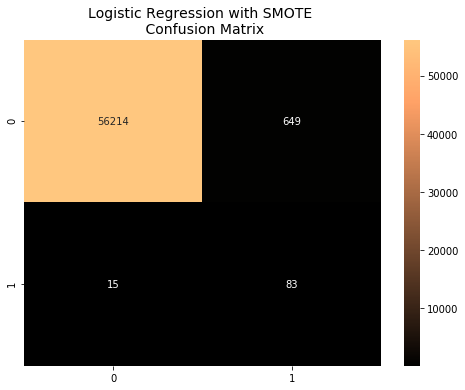

In [89]:
# Logistic Regression fitted using SMOTE technique

y_pred_log_reg = log_reg_sm.predict(original_Xtest)

log_reg_cf = confusion_matrix(original_ytest, y_pred_log_reg)

plt.figure(figsize = (8,6))
sns.heatmap(log_reg_cf, annot=True, fmt="d", cmap=plt.cm.copper)
plt.title("Logistic Regression with SMOTE \n Confusion Matrix", fontsize=14);

That's the "No fraud detected" class (Top right square) that is the most wrongly predicted, that's not bad, but worse than "fraud detected" class (bottom left square ). I think the model caught quite well the structure of the data with SMOTE but due to the SMOTE technique who increase the number of "fraud cases", the model tend to predict more often into this category. 

Personnaly, I think it's not that bad at all. It depend on the company, there is a trade off, if they want to detect more the fraud case so it's all good but if they prefer to not lose a client, categorizing them into a fraud, so maybe we need to reconsider our model. This type of question need to be discuss with the marketing pole. The Data Scientist create insight, that's not to him to decide who's better for the company, not alone. 

I found than the SMOTE technique work better than undersampling. The aim of this project is not to find the better model, but to find answer with imbalanced dataset and avoir overfitting instead. 

Now, we will focus on Deep Learning rather than machine learning. 

<a id="9"></a> <br>
## Neural Networks Testing Random UnderSampling Data vs OverSampling (SMOTE):

Here we will implement a simple Neural Network (with one hidden layer) in order to see which of the two logistic regressions models we implemented in the (undersample or oversample(SMOTE)) has a better accuracy for detecting fraud and non-fraud transactions.

Our main goal is to explore how our simple neural network behaves in both the random undersample and oversample dataframes and see whether they can predict accuractely both non-fraud and fraud cases. 

In this final phase of testing we will fit this model in both the random undersampled subset and oversampled dataset (SMOTE) in order to predict the final result using the original dataframe testing data.

**Keras || Random UnderSampling**

In [96]:
n_inputs = X_train.shape[1]

undersample_model = Sequential([
    Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])

undersample_model.compile(Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [97]:
undersample_model.fit(X_train, y_train, validation_split=0.2, batch_size=25, epochs=20, shuffle=True, verbose=2)

Train on 535 samples, validate on 134 samples
Epoch 1/20
 - 0s - loss: 0.5460 - accuracy: 0.6617 - val_loss: 0.4106 - val_accuracy: 0.8060
Epoch 2/20
 - 0s - loss: 0.3167 - accuracy: 0.8991 - val_loss: 0.3436 - val_accuracy: 0.8657
Epoch 3/20
 - 0s - loss: 0.2326 - accuracy: 0.9271 - val_loss: 0.3135 - val_accuracy: 0.8731
Epoch 4/20
 - 0s - loss: 0.1877 - accuracy: 0.9421 - val_loss: 0.2852 - val_accuracy: 0.8806
Epoch 5/20
 - 0s - loss: 0.1587 - accuracy: 0.9477 - val_loss: 0.2797 - val_accuracy: 0.8955
Epoch 6/20
 - 0s - loss: 0.1381 - accuracy: 0.9477 - val_loss: 0.2844 - val_accuracy: 0.8881
Epoch 7/20
 - 0s - loss: 0.1255 - accuracy: 0.9514 - val_loss: 0.2804 - val_accuracy: 0.8806
Epoch 8/20
 - 0s - loss: 0.1151 - accuracy: 0.9607 - val_loss: 0.2869 - val_accuracy: 0.8806
Epoch 9/20
 - 0s - loss: 0.1073 - accuracy: 0.9607 - val_loss: 0.2916 - val_accuracy: 0.8806
Epoch 10/20
 - 0s - loss: 0.1001 - accuracy: 0.9664 - val_loss: 0.2912 - val_accuracy: 0.8806
Epoch 11/20
 - 0s - los

In [104]:
undersample_fraud_predictions = undersample_model.predict_classes(original_Xtest, batch_size=200, verbose=0)

In [110]:
def roc_auc(predictions,target):
    '''
    This methods returns the AUC Score when given the Predictions
    and Labels
    '''
    
    fpr, tpr, thresholds = metrics.roc_curve(target, predictions)
    roc_auc = metrics.auc(fpr, tpr)
    return roc_auc

print("Auc: %.2f%%" % (roc_auc(undersample_fraud_predictions,original_ytest)))

Auc: 0.94%


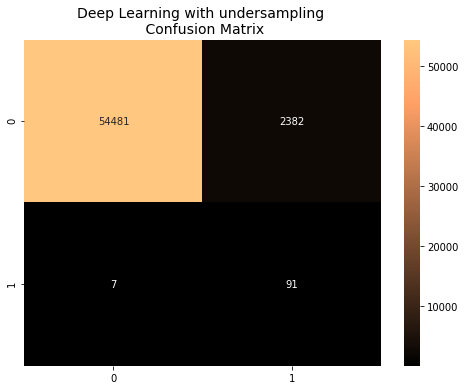

In [112]:
cm = confusion_matrix(original_ytest, undersample_fraud_predictions)

plt.figure(figsize = (8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap=plt.cm.copper)
plt.title("Deep Learning with undersampling \n Confusion Matrix", fontsize=14);

That's seems better that our machine learning model with undersampling, but not better that our machine learning model with SMOTE so let's see SMOTE !

**Keras || SMOTE**

In [115]:
n_inputs = X_rs.shape[1]

oversample_model = Sequential([
    Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])

oversample_model.compile(Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [116]:
oversample_model.fit(X_rs, y_rs, validation_split=0.2, batch_size=300, epochs=20, shuffle=True, verbose=2)

Train on 363923 samples, validate on 90981 samples
Epoch 1/20
 - 3s - loss: 0.0756 - accuracy: 0.9743 - val_loss: 0.0295 - val_accuracy: 0.9924
Epoch 2/20
 - 3s - loss: 0.0130 - accuracy: 0.9969 - val_loss: 0.0116 - val_accuracy: 0.9996
Epoch 3/20
 - 4s - loss: 0.0067 - accuracy: 0.9986 - val_loss: 0.0029 - val_accuracy: 1.0000
Epoch 4/20
 - 4s - loss: 0.0046 - accuracy: 0.9991 - val_loss: 0.0018 - val_accuracy: 1.0000
Epoch 5/20
 - 5s - loss: 0.0036 - accuracy: 0.9993 - val_loss: 0.0019 - val_accuracy: 1.0000
Epoch 6/20
 - 3s - loss: 0.0028 - accuracy: 0.9995 - val_loss: 0.0010 - val_accuracy: 1.0000
Epoch 7/20
 - 4s - loss: 0.0024 - accuracy: 0.9995 - val_loss: 0.0033 - val_accuracy: 0.9996
Epoch 8/20
 - 4s - loss: 0.0020 - accuracy: 0.9996 - val_loss: 6.8415e-04 - val_accuracy: 1.0000
Epoch 9/20
 - 4s - loss: 0.0020 - accuracy: 0.9996 - val_loss: 0.0014 - val_accuracy: 0.9998
Epoch 10/20
 - 3s - loss: 0.0018 - accuracy: 0.9996 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 11/20
 -

In [117]:
oversample_fraud_predictions = oversample_model.predict_classes(original_Xtest, batch_size=200, verbose=0)

In [118]:
print("Auc: %.2f%%" % (roc_auc(oversample_fraud_predictions,original_ytest)))

Auc: 0.83%


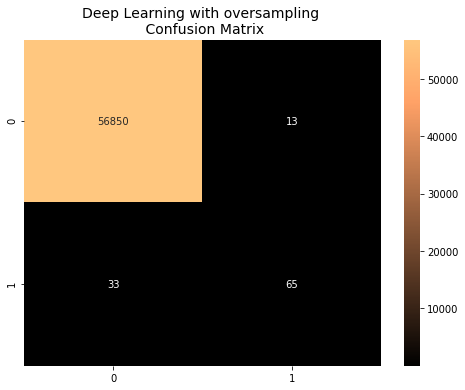

In [121]:
cm = confusion_matrix(original_ytest, oversample_fraud_predictions)

plt.figure(figsize = (8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap=plt.cm.copper)
plt.title("Deep Learning with oversampling \n Confusion Matrix", fontsize=14);

Hmmm, here the model seems to having trouble to detect the fraud cases, I think I know why, I will explain it in the conclusion.

<a id="10"></a> <br>
## Conclusion:

Implementing SMOTE on our imbalanced dataset helped us with the imbalance of our labels (more no fraud than fraud transactions). Nevertheless, I still have to state that sometimes the neural network on the oversampled dataset predicts less correct fraud transactions than our model using the undersample dataset. However, remember that the removal of outliers was implemented only on the random undersample dataset and not on the oversampled one. So I guess it's one of the reason why the last model do not perform well to predict correctly fraud transactions.

In my opinion, if you have the right computer, go for Oversampling and not undersampling. The loss of information with undersampling is significant and it sould be taken into consideration. The main problem with oversampling is the fact that it's more computationnaly expensive and I think it's less problematic, again if you have the right computer.